In [24]:
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

In [25]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')


marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

# step 3: set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

merged_df = customers.join(engagement).join(transactions_agg).join(marketing_agg)
merged_df

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


## Data Cleaning + Feature Engineering

In [26]:
# Going to use these features to build a custom model with RF + other features to predict Monetary (CLV) Value

merged_df['average_spend_total'] = merged_df['transaction_amount']/merged_df['transaction_id']
merged_df['join_date'] = pd.to_datetime(merged_df['join_date'])
merged_df['last_purchase_date'] = pd.to_datetime(merged_df['last_purchase_date'])
merged_df['customer_age'] = merged_df['last_purchase_date'] - merged_df['join_date']
merged_df['transaction_frequency_avg'] = merged_df['customer_age'] / merged_df['transaction_id']
merged_df['transaction_frequency_avg'] = merged_df['transaction_id'].astype(int)

merged_df['customer_age'] = merged_df['customer_age'].dt.days

#Gender Encoding
merged_df['gender'] = merged_df['gender'].fillna(0)
merged_df['gender'] = merged_df['gender'].astype(str)

#One Hot Encode the Gender variable
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
gender_encoded = encoder.fit_transform(merged_df[['gender']])
gender_encoded_df = pd.DataFrame(gender_encoded, columns=encoder.get_feature_names_out(['gender']))
gender_encoded_df.index = gender_encoded_df.index + 1
gender_encoded_df


#Engagement Variable
scaler = MinMaxScaler()

engagement_df = merged_df[['number_of_clicks', 'number_of_site_visits', 'number_of_emails_opened']] 
n_engagement_df = pd.DataFrame(scaler.fit_transform(engagement_df), columns=engagement_df.columns)
n_engagement_df['engagement_score'] = n_engagement_df.sum(axis=1)

low_threshold = n_engagement_df['engagement_score'].quantile(0.33)
medium_threshold = n_engagement_df['engagement_score'].quantile(0.66)

def assign_tier(score):
    if score <= low_threshold:
        return 'low'
    elif score <= medium_threshold:
        return 'medium'
    else:
        return 'high'


n_engagement_df['engagement_tier'] = n_engagement_df['engagement_score'].apply(assign_tier)
n_engagement_df.index = n_engagement_df.index + 1
n_engagement_df


merged_df[['engagement_score', 'engagement_tier']] = n_engagement_df[['engagement_score', 'engagement_tier']]
merged_df

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,average_spend_total,customer_age,transaction_frequency_avg,engagement_score,engagement_tier
customer_id,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,584.913333,118,6,0.059034,low
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,675.702222,777,9,0.913550,high
3,2021-06-01,2022-11-27,NaN,0,North Latoyatown,192,73,25,6,1454.87,1.0,242.478333,544,6,0.677637,high
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,393.734000,243,20,0.363023,medium
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,646.856250,494,24,0.271217,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,549.820000,240,10,0.424898,medium
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,487.358333,200,12,0.200976,medium
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,1167.710000,135,3,0.154588,medium


## Visualizations to determine if any patterns in the dataset

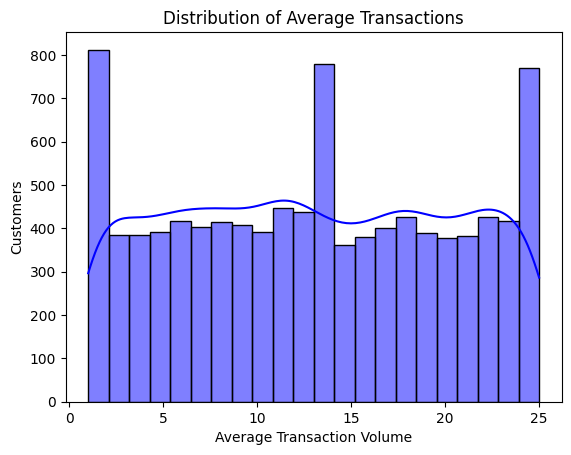

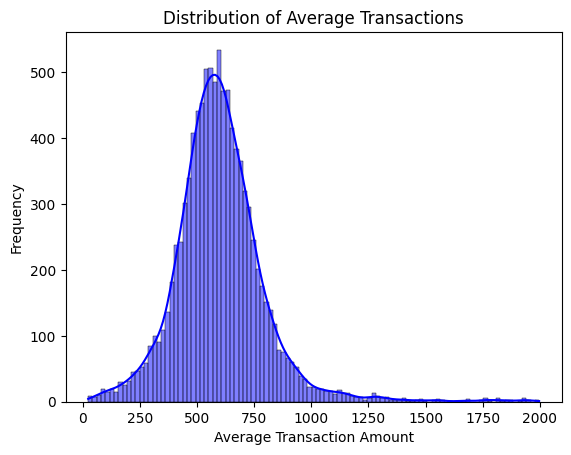

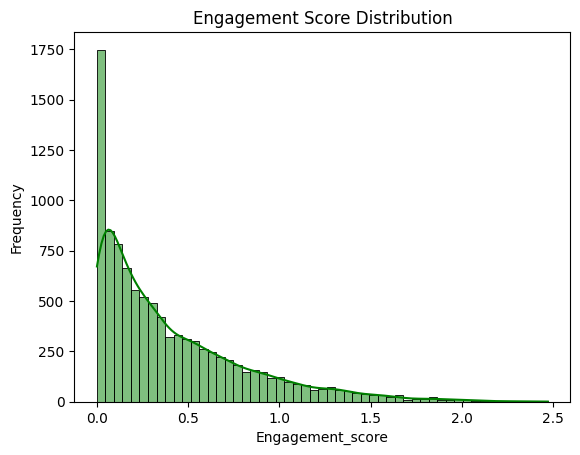

In [27]:
sns.histplot(merged_df['transaction_id'], kde=True, color='blue')  # KDE adds a density curve
plt.title('Distribution of Average Transactions')
plt.xlabel('Average Transaction Volume')
plt.ylabel('Customers')
plt.show()


sns.histplot(merged_df['average_spend_total'], kde=True, color='blue')  # KDE adds a density curve
plt.title('Distribution of Average Transactions')
plt.xlabel('Average Transaction Amount')
plt.ylabel('Frequency')
plt.show()

sns.histplot(merged_df['engagement_score'], kde=True, color='green')  # KDE adds a density curve
plt.title('Engagement Score Distribution')
plt.xlabel('Engagement_score')
plt.ylabel('Frequency')
plt.show()

## Time splitting to segment data to predict most recent 90 days of CLV

In [28]:
#Split the Transaction Data
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

n_days = 90
n_days_rfm = 360
max_date = transactions['transaction_date'].max() ## May 31, 2024
cutoff = max_date - pd.to_timedelta(n_days, unit="d")
rfm_cutoff_date = cutoff - pd.Timedelta(n_days_rfm, unit='d')  # Cutoff date for RFM calculation

temporal_in_df = transactions[transactions['transaction_date'] <= cutoff] #Using this to predict the output
temporal_out_df = transactions[transactions['transaction_date'] > cutoff] #Predicting the output

#Encompasses all transactional data that has occured 360 days prior to the cut off date of March 3, 2024
rfm_in_df = transactions[(transactions['transaction_date'] > rfm_cutoff_date) & (transactions['transaction_date'] <= cutoff)]

In [29]:
temporal_in_df

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics
5,6,1,2024-01-09,174.72,Clothing
...,...,...,...,...,...
129540,129541,10000,2023-05-27,371.70,Home Goods
129541,129542,10000,2023-06-11,1245.23,Electronics
129542,129543,10000,2023-06-28,745.74,Electronics
129543,129544,10000,2023-07-21,587.37,Home Goods


In [30]:
temporal_out_df

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
2,3,1,2024-03-12,146.86,Home Goods
83,84,7,2024-05-18,866.44,Home Goods
85,86,7,2024-05-13,131.54,Home Goods
86,87,7,2024-05-05,20.18,Clothing
252,253,21,2024-04-19,148.29,Home Goods
...,...,...,...,...,...
129427,129428,9991,2024-04-22,774.53,Electronics
129428,129429,9991,2024-04-26,832.99,Electronics
129429,129430,9991,2024-04-02,1982.51,Electronics
129430,129431,9991,2024-04-29,351.60,Home Goods


In [31]:
#Target values to see if the model can predict the most recent 90 days
targets_df = temporal_out_df.drop(columns=['transaction_date','transaction_id','product_category'], axis=1).groupby('customer_id').sum()\
    .rename({'transaction_amount' : '90_day_spend_total'}, axis=1).assign(spend_90_flag = 1)

targets_df #90 day spend total is our Monetary metric were trying to predict

,90_day_spend_total,spend_90_flag
customer_id,,
1,146.86,1
7,1018.16,1
21,148.29,1
37,2136.82,1
38,299.14,1
...,...,...
9956,318.59,1
9973,4729.27,1
9976,456.78,1


## RFM Segmentation

In [32]:
#RFM Function

def calculate_rfm(data, end_date, days_label):
    rfm = data.groupby('customer_id').agg(
        recency = ('transaction_date', lambda x: (end_date - x.max()).days),
        frequency = ('transaction_id', 'count'),
        monetary = ('transaction_amount', 'sum')
    ).rename(columns={
        'recency': f'Recency_{days_label}',
        'frequency': f'Frequency_{days_label}',
        'monetary': f'Monetary_{days_label}'
    })
    return rfm

In [33]:
rfm_df = calculate_rfm(rfm_in_df, cutoff, 360)
rfm_df = pd.merge(rfm_df, targets_df, left_index=True, right_index=True, how='left').fillna(0)
rfm_df

,Recency_360,Frequency_360,Monetary_360,90_day_spend_total,spend_90_flag
customer_id,,,,,
1,0,5,3362.62,146.86,1.0
5,275,5,1219.00,0.00,0.0
7,72,2,321.66,1018.16,1.0
8,215,12,9231.49,0.00,0.0
9,216,5,2320.39,0.00,0.0
...,...,...,...,...,...
9990,28,23,16274.45,0.00,0.0
9992,29,18,12543.37,0.00,0.0
9996,265,3,1096.25,0.00,0.0


In [34]:
#Include other features into the RFM dataframe
rfm_df['average_spend_total'] = merged_df['average_spend_total']
rfm_df['customer_life_in_days'] = merged_df['customer_age']
rfm_df['engagement_score'] = merged_df['engagement_score']
rfm_df['avg_transaction_frequency'] = merged_df['transaction_frequency_avg']
rfm_df[['gender_0', 'gender_Female', 'gender_Male']] = gender_encoded_df[['gender_0', 'gender_Female', 'gender_Male']]

# Assign RFM scores (using quintiles)
rfm_df['R_score'] = pd.qcut(rfm_df['Recency_360'], 5, labels=[5, 4, 3, 2, 1],duplicates='drop')
rfm_df['F_score'] = pd.qcut(rfm_df['Frequency_360'], 5, labels=[1, 2, 3, 4, 5],duplicates='drop')
rfm_df['M_score'] = pd.qcut(rfm_df['Monetary_360'], 5, labels=[1, 2, 3, 4, 5],duplicates='drop')

# Combine RFM scores into a single score
rfm_df['RFM_score'] = rfm_df[['R_score', 'F_score', 'M_score']].sum(axis=1)
rfm_df['CLV_category'] = pd.qcut(rfm_df['RFM_score'], 3, labels=['low', 'medium', 'high'])
rfm_df

,Recency_360,Frequency_360,Monetary_360,90_day_spend_total,spend_90_flag,average_spend_total,customer_life_in_days,engagement_score,avg_transaction_frequency,gender_0,gender_Female,gender_Male,R_score,F_score,M_score,RFM_score,CLV_category
customer_id,,,,,,,,,,,,,,,,,
1,0,5,3362.62,146.86,1.0,584.913333,118,0.059034,6,0.0,1.0,0.0,5,2,3,10,medium
5,275,5,1219.00,0.00,0.0,646.856250,494,0.271217,24,0.0,0.0,1.0,1,2,2,5,low
7,72,2,321.66,1018.16,1.0,267.964000,170,0.134127,5,0.0,1.0,0.0,4,1,1,6,low
8,215,12,9231.49,0.00,0.0,780.708000,181,0.195188,15,0.0,0.0,1.0,2,4,5,11,medium
9,216,5,2320.39,0.00,0.0,471.952727,568,0.348522,22,0.0,1.0,0.0,2,2,2,6,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,28,23,16274.45,0.00,0.0,707.584783,251,0.113892,23,0.0,1.0,0.0,4,5,5,14,high
9992,29,18,12543.37,0.00,0.0,696.853889,22,0.011268,18,0.0,1.0,0.0,4,5,5,14,high
9996,265,3,1096.25,0.00,0.0,549.820000,240,0.424898,10,0.0,1.0,0.0,1,2,1,4,low


## Random Forest Regression Model 

In [35]:
# MACHINE LEARNING ---- RandomForest

X = rfm_df[['Recency_360', 'Frequency_360','Monetary_360','customer_life_in_days',\
                 'engagement_score','gender_Female', 'gender_Male', 'average_spend_total']]

# NEXT 90-DAY SPEND (Monetary 90 day) prediction

y_spend = rfm_df['90_day_spend_total']


In [36]:
# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=1234)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

rf_grid_search = GridSearchCV(estimator=model, 
                              param_grid=param_grid, 
                              scoring='neg_mean_absolute_error', 
                              cv=5, 
                              refit=True,
                              n_jobs=-1,  # Use all available cores
                              verbose=2)  # Print progress

In [37]:
# Fit the model
rf_grid_search.fit(X, y_spend)

# Make predictions
y_pred = rf_grid_search.predict(X)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=

In [38]:
# Evaluate the regression model 
mae = mean_absolute_error(y_spend, y_pred)
mse = mean_squared_error(y_spend, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_spend, y_pred)
best_score = rf_grid_search.best_score_

print(f"Best parameters: {rf_grid_search.best_params_}")
print(f"Best cross-validation score: {best_score}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: -454.4896873269644
Mean Absolute Error (MAE): 263.8781793514795
Mean Squared Error (MSE): 407373.71397908113
Root Mean Squared Error (RMSE): 638.2583442298903
R-squared (R²): 0.835532917542346


In [39]:
rfm_df['spend_90_flag'].value_counts()

spend_90_flag
0.0    4234
1.0     981
Name: count, dtype: int64

## Classification Model (Logistic Regression) 

In [40]:
# NEXT 90-DAY SPEND PROBABILITY

X_class = rfm_df[['R_score', 'F_score', 'M_score']]

y_prob = rfm_df['spend_90_flag']

log_reg = LogisticRegression(random_state=123)

In [41]:
knn = KNeighborsClassifier()
logreg = LogisticRegression()
nb = GaussianNB()

knn_scores = cross_val_score(knn, X_class, y_prob, scoring='f1', cv=5)
logreg_scores = cross_val_score(logreg, X_class, y_prob, scoring='f1', cv=5)
nb_scores = cross_val_score(nb, X_class, y_prob, scoring='f1', cv=5)

print(np.mean(knn_scores))
print(np.mean(logreg_scores))
print(np.mean(nb_scores))

0.6396796319895025
0.6876617505346365
0.6351906201238856


In [42]:
categorical = rfm_df[['R_score', 'F_score', 'M_score']]
numerical = ['']
target = rfm_df['spend_90_flag']

# train and test set
X_train, X_test, y_train, y_test = train_test_split(rfm_df[categorical + numerical], rfm_df[target], test_size=0.3, random_state=123)

#Feature Transformers - Applying OneHotEncoding and MinMaxScaler
# prevent one hot encoder from returning a sparse matrix (GuassianNB will throw an error otherwise)
catTransformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
numTransformer = Pipeline(steps = [('scaler', MinMaxScaler())])

#Build Preprocessor
preprocessor = ColumnTransformer(transformers = [('cat', catTransformer, categorical), ('num', numTransformer, numerical)])

ValueError: Unable to coerce to Series, length must be 3: given 1

In [ ]:
log_reg = LogisticRegression(random_state=123)

param_grid = {
    'penalty': ['l1'],
    'C': [1],
    'solver': ['liblinear'],  # solvers that support 'l1' and 'elasticnet'
    'l1_ratio': [0]  # Only used if penalty is 'elasticnet'
}

# Use GridSearchCV to find the best combination of hyperparameters
log_reg_grid_search = GridSearchCV(estimator=log_reg, 
                                   param_grid=param_grid, 
                                   scoring='roc_auc', 
                                   cv=5, 
                                   refit=True,
                                   n_jobs=-1,  # Use all available cores
                                   verbose=2)  # Print progress

In [ ]:
# Fit the model
log_reg_grid_search.fit(X_class, y_prob)

# Make predictions
y_prob_grid = log_reg_grid_search.predict_proba(X_class)[:, 1]  # Probability estimates of the positive class
y_prob_grid

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ......C=1, l1_ratio=0, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=1, l1_ratio=0, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=1, l1_ratio=0, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=1, l1_ratio=0, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ......C=1, l1_ratio=0, penalty=l1, solver=liblinear; total time=   0.0s


/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/steven.souksavath/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_rat

array([0.68814758, 0.0017607 , 0.32473899, ..., 0.0019125 , 0.26655356,
       0.00716663])

In [ ]:
# Get the best parameters and best score
best_params = log_reg_grid_search.best_params_
best_score = log_reg_grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score (ROC AUC): {best_score}")


accuracy = accuracy_score(y_prob, y_prob_grid)


Best parameters: {'C': 1, 'l1_ratio': 0, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score (ROC AUC): 0.9049175659885973


ValueError: Classification metrics can't handle a mix of binary and continuous targets